In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from processing.processing import PreProcessing, Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [2]:
old_data = PreProcessing.read_davidson_data("data/Davidson&al.csv")

data = old_data.copy()
old_data.tweet = old_data.tweet.apply(lambda t: PreProcessing.sanitize_tweet(t, with_stemmer=False))
data.tweet = data.tweet.apply(PreProcessing.sanitize_tweet)
ol = data[data["class"] == "offensive language"][:5000] # Only get 5000 samples for offensive language otherwise the model will tend to classify hate speech as offensive language which is a little different.
data = data[data["class"] != "offensive language"].append(ol)

In [3]:
clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3))), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier()),])
clf = clf.fit(data["tweet"], data["class"])

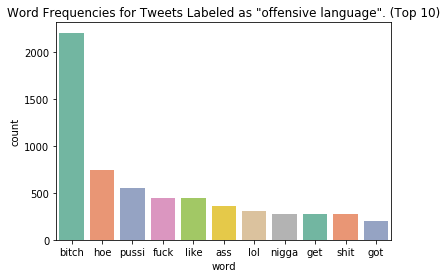

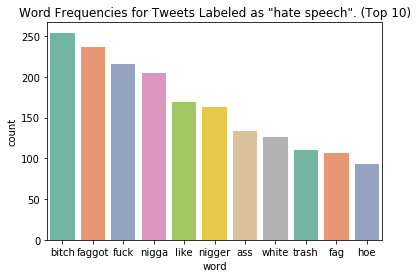

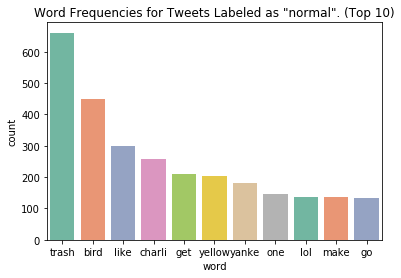

In [4]:
an = Analysis(data)
plt.figure()
an.plot_frequent_words_by_class("offensive language")
plt.figure()
an.plot_frequent_words_by_class("hate speech")
plt.figure()
an.plot_frequent_words_by_class("normal")

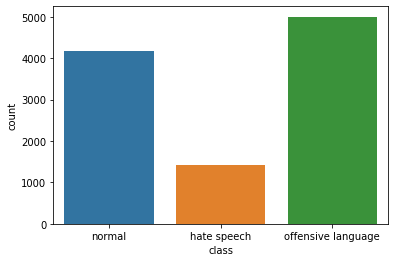

In [5]:
sns.countplot(x="class", data=data)

In [6]:
print(metrics.classification_report(data["class"], clf.predict(data["tweet"])))

precision    recall  f1-score   support

       hate speech       0.97      0.86      0.91      1430
            normal       0.89      0.99      0.94      4163
offensive language       0.96      0.90      0.93      5000

          accuracy                           0.93     10593
         macro avg       0.94      0.92      0.93     10593
      weighted avg       0.93      0.93      0.93     10593



In [7]:
print(metrics.classification_report(old_data["class"], clf.predict(old_data["tweet"])))

precision    recall  f1-score   support

       hate speech       0.48      0.60      0.54      1430
            normal       0.44      0.97      0.61      4163
offensive language       0.97      0.70      0.81     19190

          accuracy                           0.74     24783
         macro avg       0.63      0.76      0.65     24783
      weighted avg       0.85      0.74      0.76     24783



In [8]:
model = Word2Vec([s.split() for s in old_data.tweet.tolist()])

In [9]:
len(model.wv.vocab)

3842

In [10]:
stats = an.check_metrics_with_less_data("offensive language")

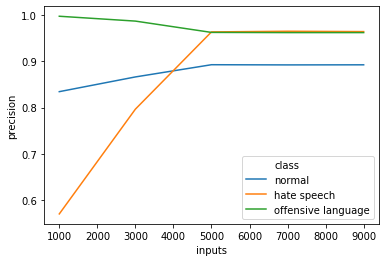

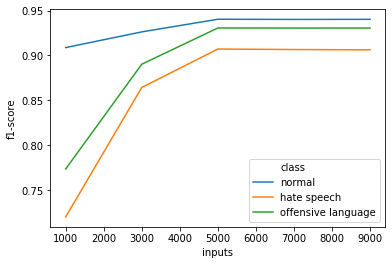

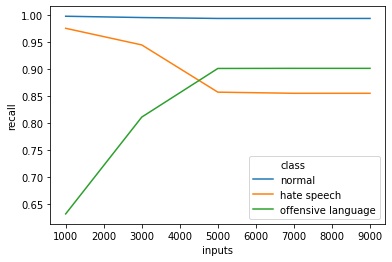

In [11]:
plt.figure()
sns.lineplot(data=stats, x="inputs", y="precision", hue="class")
plt.figure()
sns.lineplot(data=stats, x="inputs", y="f1-score", hue="class")
plt.figure()
sns.lineplot(data=stats, x="inputs", y="recall", hue="class")
